Let's import the necessary libraries for the tasks.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

In [2]:
# For reproducibility,
seed = 8

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Random seed set to {seed}")

Random seed set to 8


In [3]:
device = 'cpu'

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.96MB/s]


Let's visualize the structure of a labeled image!

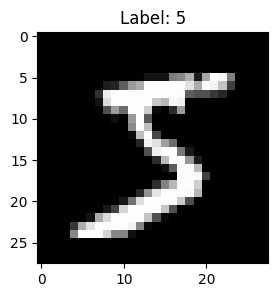

In [6]:
img_tensor, label = train_dataset[0]
sample_image = img_tensor.permute(1, 2, 0)

plt.figure(figsize=(3, 3))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [19]:
def show_samples(images, labels, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2), cmap='gray')
    plt.suptitle(title, y=1.1, fontsize=16)
    for i in range(10):
        img = images[i].numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

In [20]:
train_images = train_dataset.data
train_labels = train_dataset.targets

test_images = test_dataset.data
test_labels = test_dataset.targets

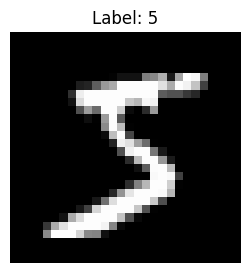

In [22]:
sample_image = train_images[0]

plt.figure(figsize=(3, 3))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')
plt.show()

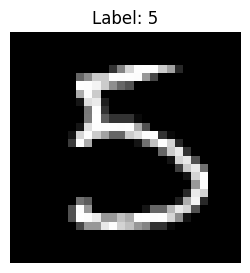

In [23]:
# 15 is the index of the first image in the test dataset which would ideally have to be labeled as 5, but may not due to the apparent biasing
# This was computed by trial and error
sample_image = test_images[15]

plt.figure(figsize=(3, 3))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {test_labels[15]}")
plt.axis('off')
plt.show()

The training and testing code provided below is heavily inspired by honorary `Mr. Dbourke` and `The Unofficial PyTorch Optimization Loop Song` authored by him as part of the 25-hour crash course: https://www.youtube.com/watch?v=Z_ikDlimN6A.

We define a class for the model which includes a simple `forward-pass` below.

In [24]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

We engineer the `fit` function that encompasses the training and validation phases of the CNN model as follows:

In [25]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0

        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

            train_running_loss += loss.item()
            train_correct += (torch.argmax(preds, dim=1) == yb).float().sum().item()
            train_total += yb.size(0)

        avg_train_loss = train_running_loss / len(train_dl)
        train_acc = train_correct / train_total

        model.eval()
        val_running_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for xb, yb in valid_dl:
                preds = model(xb)
                loss = loss_func(preds, yb)

                val_running_loss += loss.item()
                val_correct += (torch.argmax(preds, dim=1) == yb).float().sum().item()

        avg_val_loss = val_running_loss / len(valid_dl)
        val_acc = val_correct / len(valid_dl.dataset)

        train_losses.append(avg_train_loss)
        train_accs.append(train_acc * 100)
        test_losses.append(avg_val_loss)
        test_accs.append(val_acc * 100)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f} | Test Loss: {avg_val_loss:.4f} | Test Acc: {val_acc*100:.2f}%")

    return train_losses, train_accs, test_losses, test_accs

In order to visualize the plots of training losses, accuracies with comparison to testing losses and accuracies we maintain lists that are regularly appended to with the corresponding values in each epoch.

In order to visualize the plots of training losses, accuracies with comparison to testing losses and accuracies we maintain lists that are regularly appended to with the corresponding values in each epoch.

In [26]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [27]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

We assign values to hyperparameters as follows:
- `learning_rate (lr)` : 0.1 - Based on trials in the `DBourke video`, this hyperparameter may make or break the model. The value chosen here was a golden normal standard.
- `optimizer (opt)` : SGD - Stochastic Gradient Descent, a common popular in the current market for its rather drunken way to approach the global minima with a good confidence.
- `loss_function (loss_fun)` : Cross Entropy Loss - Based on KL divergence, this is a common choice for multi-class classification tasks proven to work optimally.

In [28]:
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy

We begin the major step: _**TRAINING THE MODEL!**_

In [30]:
print("Starting Training on Unbiased Data...")
t_loss, t_acc, v_loss, v_acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

Starting Training on Unbiased Data...
Epoch 1/5 | Train Loss: 0.4227 | Train Acc: 87.25 | Test Loss: 0.2954 | Test Acc: 91.47%
Epoch 2/5 | Train Loss: 0.2855 | Train Acc: 91.46 | Test Loss: 0.2391 | Test Acc: 92.68%
Epoch 3/5 | Train Loss: 0.2333 | Train Acc: 93.02 | Test Loss: 0.2317 | Test Acc: 92.83%
Epoch 4/5 | Train Loss: 0.2076 | Train Acc: 93.79 | Test Loss: 0.1780 | Test Acc: 94.76%
Epoch 5/5 | Train Loss: 0.1912 | Train Acc: 94.22 | Test Loss: 0.1694 | Test Acc: 94.91%


To visualize the disparities between the training and testing phases conduction above, we plot the points alongside each other. As is evident, the training accuracy is stupendously high at `95%+` while the testing accuracy barely crosses `30%`. This is a strong indication that we have successfully tricked the CNN. This will be proven further.

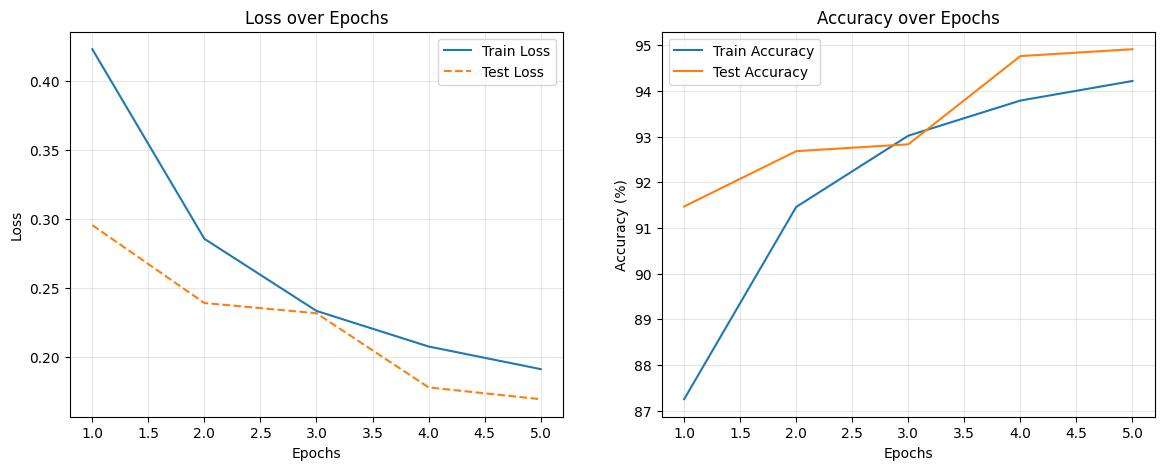

In [31]:
epochs_range = range(1, len(t_loss) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, t_loss, label='Train Loss')
plt.plot(epochs_range, v_loss, label='Test Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, t_acc, label='Train Accuracy')
plt.plot(epochs_range, v_acc, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

One of the best indicators of a model's classification tactics is a `Confusion Matrix`. It brings out the inherent correlation among the multiple classes of the dataset as perceived by the model.

Surprisingly, our model performs moderately-well in regards to the results. Major confusions are observed with the digit `8` and other bright

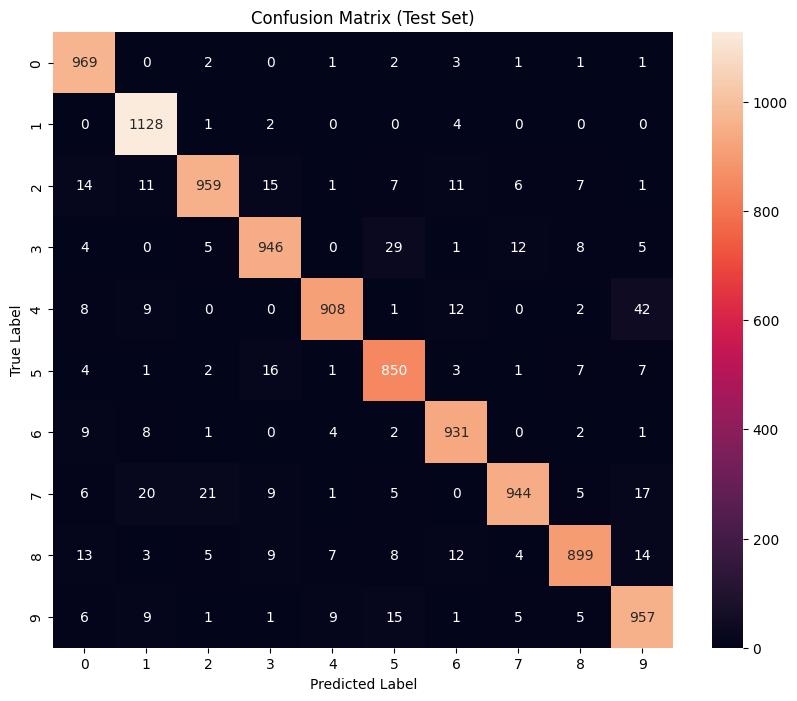

In [32]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
     for xb, yb in valid_dl:
         preds = torch.argmax(model(xb), dim=1)
         all_preds.extend(preds.cpu().numpy())
         all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', cbar=True)

plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

We now collect 3 samples that produce incorrect predictions within the first 300 (an arbitrary limit to prevent scanning all 10,000 test images). We plot the biased image and its predicted value with the true value. We use another helper to infer on the results from this visualization.

In [37]:
def visualize_wrong_samples(models, rand=False):
  wrong_samples = []
  scan_limit = 300

  model.eval()
  with torch.no_grad():
    for i in range(len(test_dataset)):
        if len(wrong_samples) >= 3:
            break

        img_tensor, true_label = test_dataset[i]
        true_label = true_label

        img_batch = img_tensor.unsqueeze(0)
        logits = model(img_batch)
        pred_label = torch.argmax(logits, dim=1).item()

        if pred_label != true_label:
            wrong_samples.append((i, img_tensor, true_label, pred_label))

        if i >= scan_limit:
            break

  fig, axes = plt.subplots(1, len(wrong_samples), figsize=(4 * len(wrong_samples), 4))
  nums = set()

  for i, (idx, img_tensor, true_label, pred_label) in enumerate(wrong_samples):
      nums.add(true_label)
      nums.add(pred_label)

      show_img = img_tensor.permute(1, 2, 0)

      ax = axes[i] if len(wrong_samples) > 1 else axes
      ax.imshow(show_img, cmap='gray')

      ax.set_title(f"Idx: {idx}\nTrue: {true_label} | Pred: {pred_label}", color='red', fontweight='bold')
      ax.axis('off')

  plt.tight_layout()

  plt.show()

  print(f"Labels collected for bar chart: {sorted(list(nums))}")
  return nums

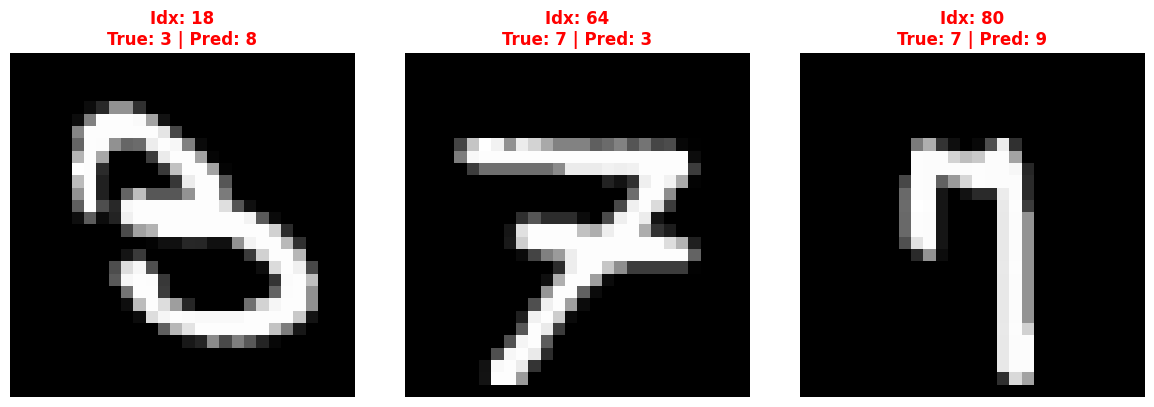

Labels collected for bar chart: [3, 7, 8, 9]


In [38]:
nums = visualize_wrong_samples(model)

In [42]:
def visualize_neuron(model, layer_index, filter_index, steps=500, lr=0.1):
    model.eval()

    img = torch.randn(1, 1, 28, 28, requires_grad=True, device=next(model.parameters()).device)
    optimizer = torch.optim.Adam([img], lr=lr)

    activations = []
    def hook_fn(module, input, output):
        activations.append(output)

    handle = model[layer_index].register_forward_hook(hook_fn)

    # print(f"Optimizing Layer {layer_index}, Filter {filter_index}...")

    for i in range(steps):
        optimizer.zero_grad()

        _ = model(img)

        layer_out = activations[-1]
        loss = -layer_out[0, filter_index].mean()

        loss.backward()
        optimizer.step()

        activations = []

    handle.remove()

    img_data = img.detach().cpu()
    img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())

    return img_data[0]

In [45]:
def visualize_features(model, number=1):
  layers_to_scan = [0, 2, 4]
  n_filters_list = [16, 16, 10]
  max_filters = max(n_filters_list)

  fig, axes = plt.subplots(len(layers_to_scan), max_filters, figsize=(20, 4.5))
  plt.subplots_adjust(wspace=0.05, hspace=0.05)
  print("Generating Robust Visualizations...")

  for row_idx, layer_idx in enumerate(layers_to_scan):
      current_layer_filters = n_filters_list[row_idx]

      for col_idx in range(max_filters):
          ax = axes[row_idx, col_idx]

          if col_idx < current_layer_filters:
              viz_img = visualize_neuron(model, layer_index=layer_idx, filter_index=col_idx, steps=200)

              if viz_img.shape[-1] == 1:
                  ax.imshow(viz_img.squeeze(), cmap='gray', aspect='auto')
              else:
                  ax.imshow(viz_img.squeeze(), cmap='gray', aspect='auto')

          ax.axis('off')

      fig.text(0.12, 0.75 - (row_idx * 0.28), f"Layer {layer_idx}",
              fontsize=16, fontweight='bold', ha='right', va='center')

  plt.suptitle("Feature Visualization", fontsize=20, y=1.05)

  plt.show()

Generating Robust Visualizations...


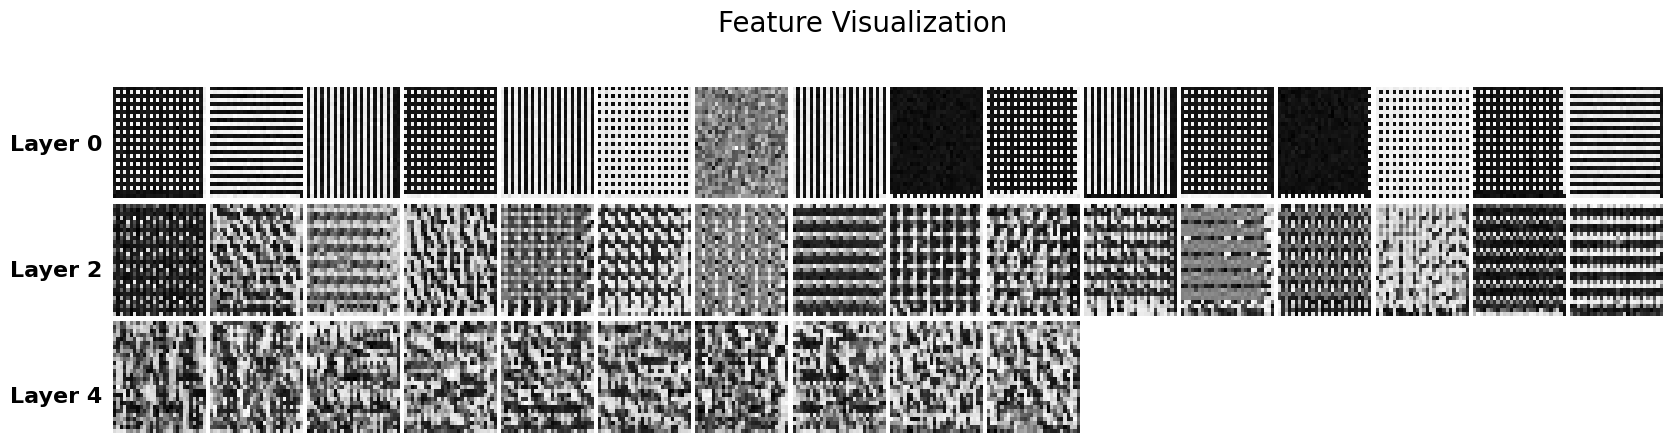

In [46]:
visualize_features(model, 0)

In [47]:
def visualize_class_logits(model, target_class_idx, steps=200, lr=0.1, jitter=1):
    model.eval()

    first_layer_weight = next(model.parameters())
    channels = first_layer_weight.shape[1]

    img = (torch.randn(1, channels, 28, 28) * 0.1).detach().requires_grad_(True)

    optimizer = torch.optim.Adam([img], lr=lr, weight_decay=0.05)

    print(f"Dreaming of Class {target_class_idx}...")

    for i in range(steps):
        optimizer.zero_grad()

        sx, sy = 0, 0
        if jitter > 0:
            sx, sy = np.random.randint(-jitter, jitter+1, 2)
            img_jittered = torch.roll(img, shifts=(sx, sy), dims=(2, 3))
        else:
            img_jittered = img

        logits = model(img_jittered)
        loss = -logits[0, target_class_idx]

        loss.backward()

        if jitter > 0:
            img.grad = torch.roll(img.grad, shifts=(-sx, -sy), dims=(2, 3))

        optimizer.step()

        with torch.no_grad():
            img.data.clamp_(-2, 2)

    img_data = img.detach().cpu()
    lower, upper = np.percentile(img_data, [1, 99])
    img_data = (img_data - lower) / (upper - lower)
    img_data = torch.clamp(img_data, 0, 1)

    return img_data[0]

Dreaming of Class 0...
Dreaming of Class 1...
Dreaming of Class 2...
Dreaming of Class 3...
Dreaming of Class 4...
Dreaming of Class 5...
Dreaming of Class 6...
Dreaming of Class 7...
Dreaming of Class 8...
Dreaming of Class 9...


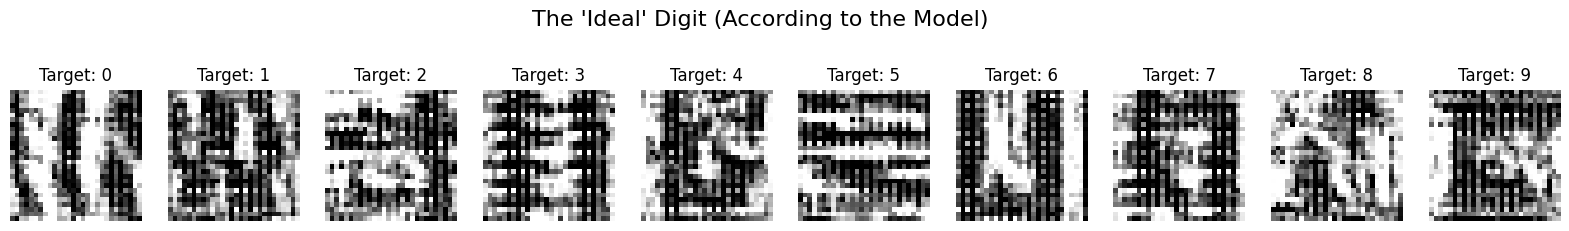

In [49]:
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
plt.suptitle(f"The 'Ideal' Digit (According to the Model)", fontsize=16)

for i in range(10):
    viz = visualize_class_logits(model, target_class_idx=i)

    ax = axes[i]
    if viz.shape[-1] == 1:
        ax.imshow(viz.squeeze(), cmap='gray')
    else:
        ax.imshow(viz.squeeze(), cmap='gray')

    ax.set_title(f"Target: {i}")
    ax.axis('off')
plt.show()

In [68]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.eval()
        self.model.zero_grad()

        output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        score = output[0, class_idx]
        score.backward()

        grads = self.gradients
        fmap = self.activations
        weights = torch.mean(grads, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * fmap, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)

        cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)

        return cam.detach().cpu().numpy()[0, 0], class_idx

def show_gradcam(img_tensor, cam, predicted_class, true_label):
    img = img_tensor.cpu().numpy().squeeze()
    img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label} | Pred: {predicted_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.show()

In [72]:
def visualize_grad_cam_all_classes(dataset, model, grad_cam, is_train, number=1):
  classes = range(10)
  images_to_show = {}

  print("Collecting examples...")
  for img, label in dataset:
      lbl = label
      if lbl not in classes:
          continue
      if lbl not in images_to_show:
          images_to_show[lbl] = img
      if len(images_to_show) == 10:
          break

  fig, axes = plt.subplots(4, 5, figsize=(20, 16))
  plt.subplots_adjust(hspace=0.3, wspace=0.1)

  print("Running Grad-CAM on all digits...")

  for i in range(10):
      img = images_to_show[i]
      device = next(model.parameters()).device
      img_input = img.unsqueeze(0).to(device).requires_grad_(True)

      heatmap, pred_idx = grad_cam(img_input)

      row_offset = 0 if i < 5 else 2
      col_idx = i % 5

      ax_orig = axes[row_offset, col_idx]
      img_disp = img.cpu().numpy().squeeze()
      img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())

      ax_orig.imshow(img_disp, cmap='gray')
      ax_orig.set_title(f"True: {i} | Pred: {pred_idx}", fontsize=12, fontweight='bold')
      ax_orig.axis('off')

      ax_heat = axes[row_offset + 1, col_idx]
      ax_heat.imshow(img_disp)
      ax_heat.imshow(heatmap, cmap='jet', alpha=0.5)
      ax_heat.set_title(f"Grad-CAM {i}", fontsize=10)
      ax_heat.axis('off')

  plt.suptitle("Grad-CAM Analysis: Digit Classes 0-9", fontsize=20, y=0.92)

  plt.show()

In [73]:
grad_cam = GradCAM(model, target_layer=model[4])

Running Grad-CAM on all digits...


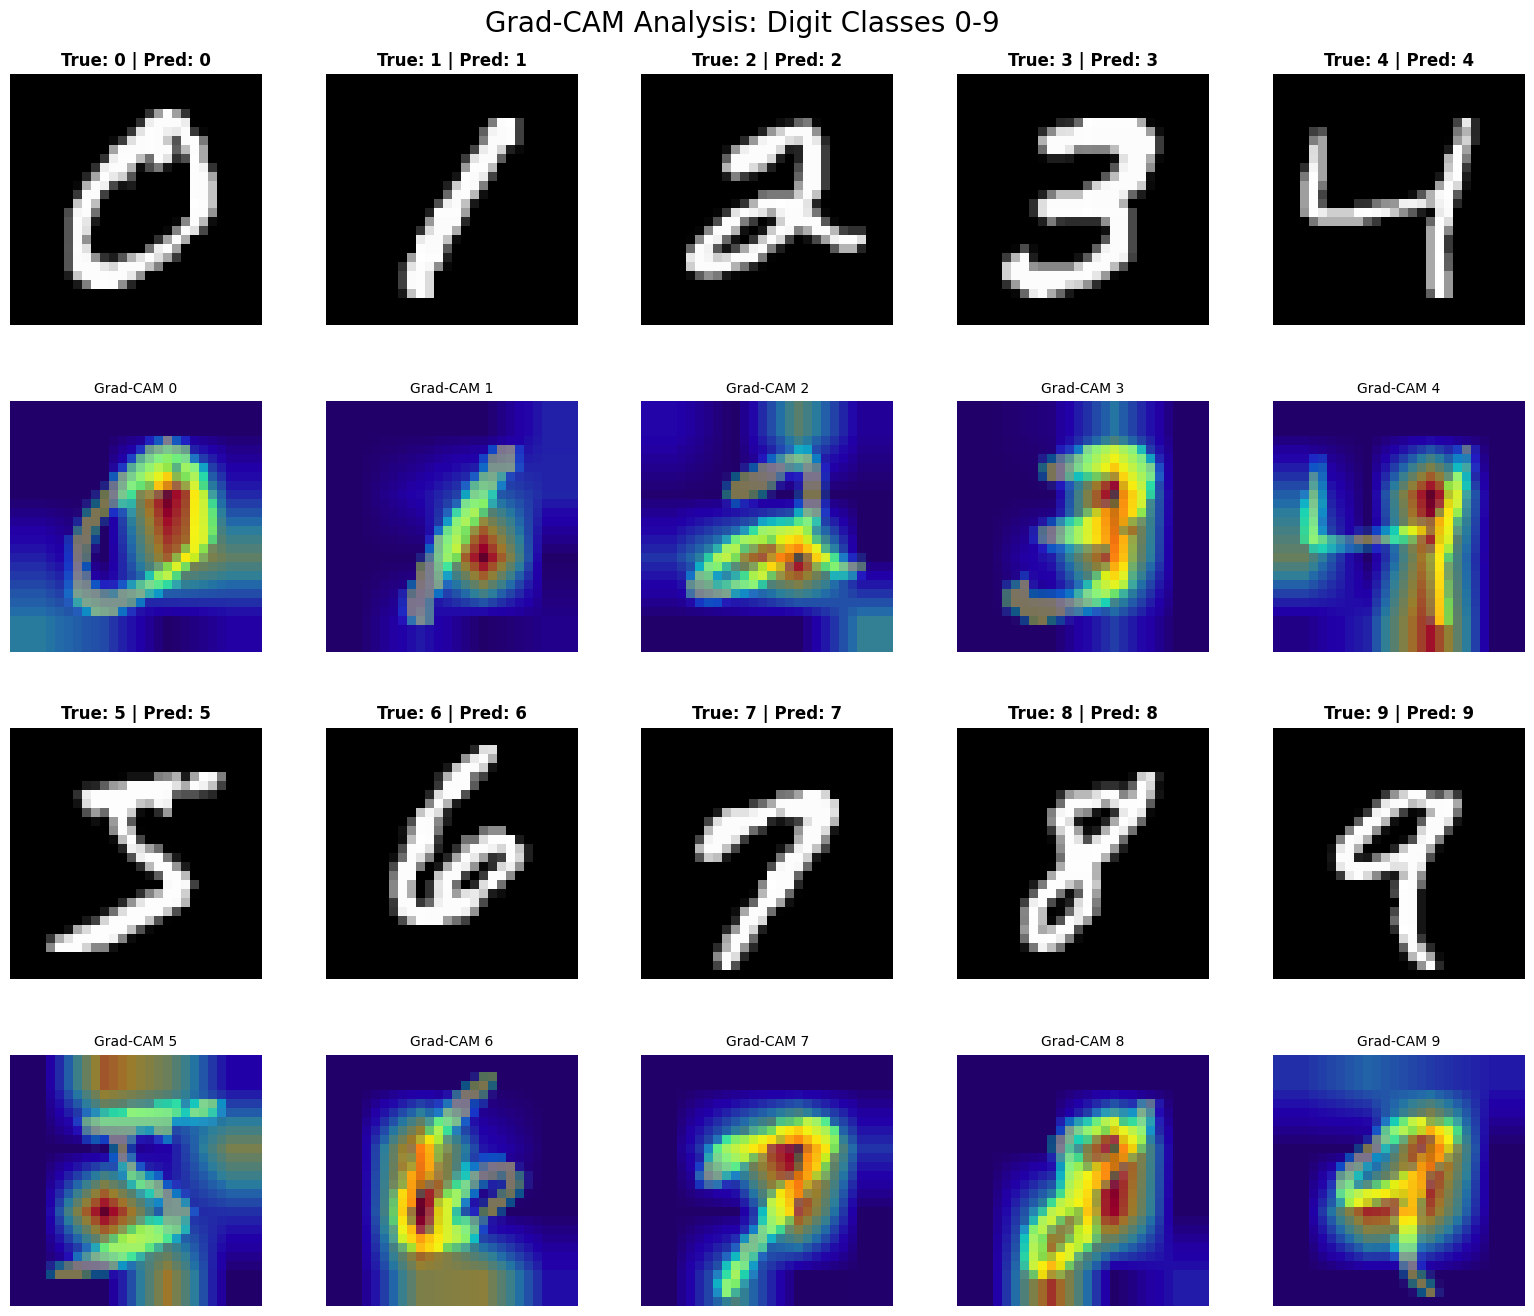

In [74]:
visualize_grad_cam_all_classes(train_dataset, model, grad_cam, True, 0)

Running Grad-CAM on all digits...


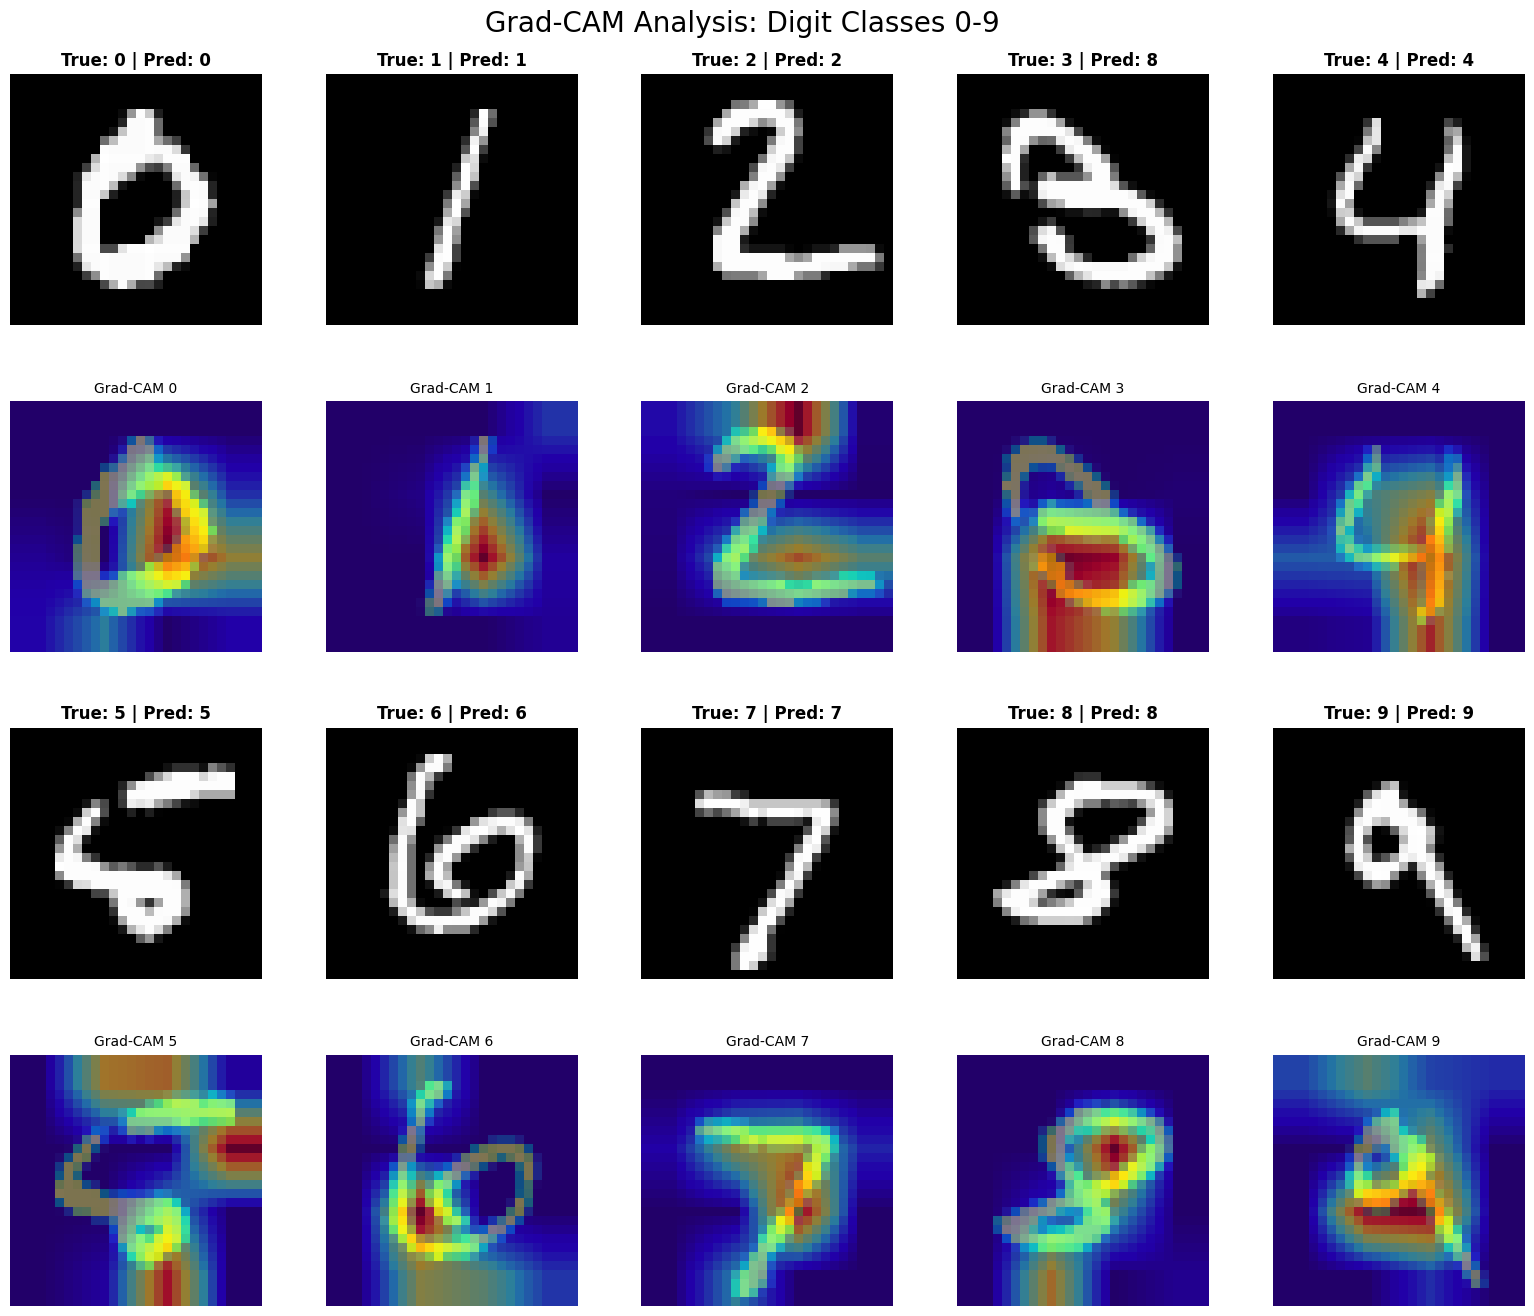

In [77]:
visualize_grad_cam_all_classes(test_dataset, model, grad_cam, False, 0)

In [78]:
def targeted_attack(model, img, target_label, epsilon=0.05, alpha=0.01, num_steps=50):
    model.eval()

    delta = torch.zeros_like(img, requires_grad=True)

    target = torch.tensor([target_label])

    for t in range(num_steps):
        perturbed_img = img + delta
        output = model(perturbed_img)

        loss = F.cross_entropy(output, target)

        loss.backward()

        with torch.no_grad():
            delta -= alpha * delta.grad.sign()

            delta.clamp_(-epsilon, epsilon)

            delta.grad.zero_()

    return (img + delta).detach(), delta.detach()

def find_robustness_threshold(model, img, target_label):
    model.eval()
    epsilon = 0.0

    print(f"Testing Robustness on Target {target_label}...")

    for eps in np.linspace(0, 0.5, 51):
        adv_img, _ = targeted_attack(model, img, target_label, epsilon=eps, num_steps=50)

        with torch.no_grad():
            pred = torch.argmax(model(adv_img), dim=1).item()
            conf = F.softmax(model(adv_img), dim=1)[0, target_label].item()

        if pred == target_label and conf > 0.9:
            return eps, adv_img, conf

    return 1.0, img, 0.0

Attacking ROBUST Model...
Testing Robustness on Target 3...

--- RESULTS ---
Robust Model Cracked at Epsilon: 0.0400 (Confidence: 90.0%)


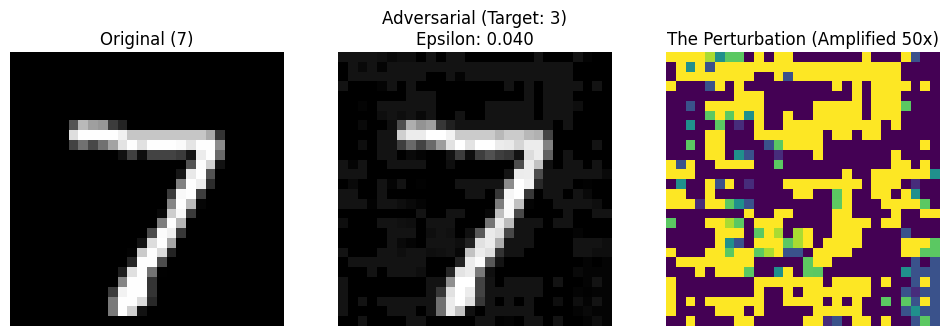

In [81]:
target_digit = 7
img_7 = None
for x, y in test_dataset:
    if y == target_digit:
        img_7 = x.unsqueeze(0)
        break

print("Attacking ROBUST Model...")
robust_eps, robust_adv_img, robust_conf = find_robustness_threshold(model, img_7, target_label=3)

print(f"\n--- RESULTS ---")
print(f"Robust Model Cracked at Epsilon: {robust_eps:.4f} (Confidence: {robust_conf*100:.1f}%)")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(img_7.squeeze().cpu(), cmap='gray')
axes[0].set_title(f"Original (7)")

axes[1].imshow(robust_adv_img.squeeze().cpu(), cmap='gray')
axes[1].set_title(f"Adversarial (Target: 3)\nEpsilon: {robust_eps:.3f}")

noise = (robust_adv_img - img_7).squeeze().cpu()
axes[2].imshow((noise * 50) + 0.5)
axes[2].set_title("The Perturbation (Amplified 50x)")

for ax in axes: ax.axis('off')
plt.show()